        date     sales
0 2015-01-03    16.448
1 2015-01-04   288.060
2 2015-01-05    19.536
3 2015-01-06  4407.100
4 2015-01-07    87.158


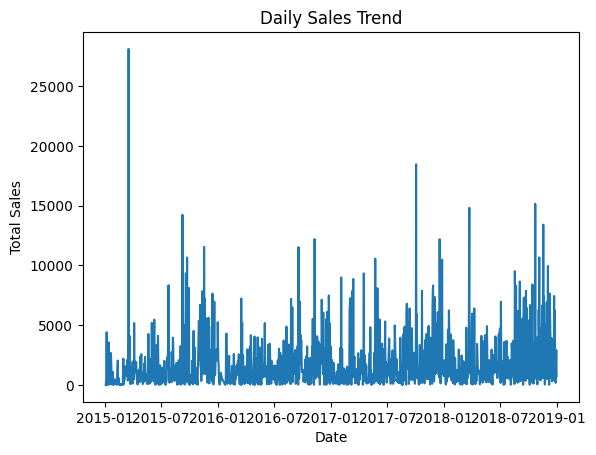


ARIMA Results
MAE : 1735.8116256356245
RMSE: 2718.951833427117


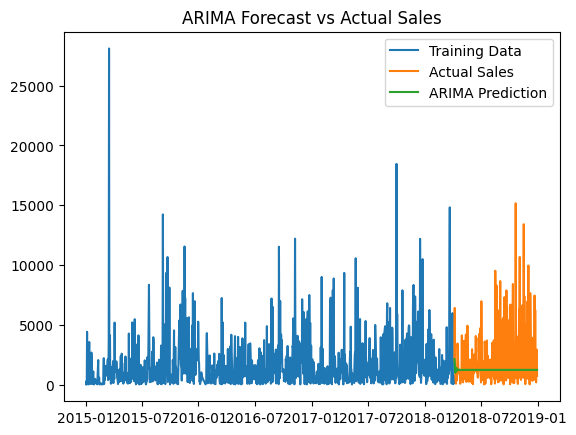


Prophet Results
MAE : 1759.8194940092121
RMSE: 2453.469508190253


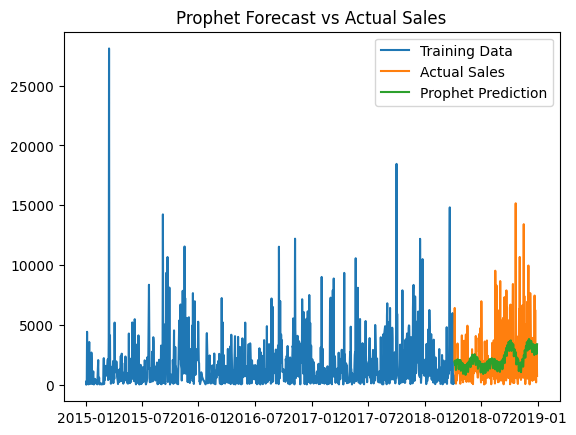

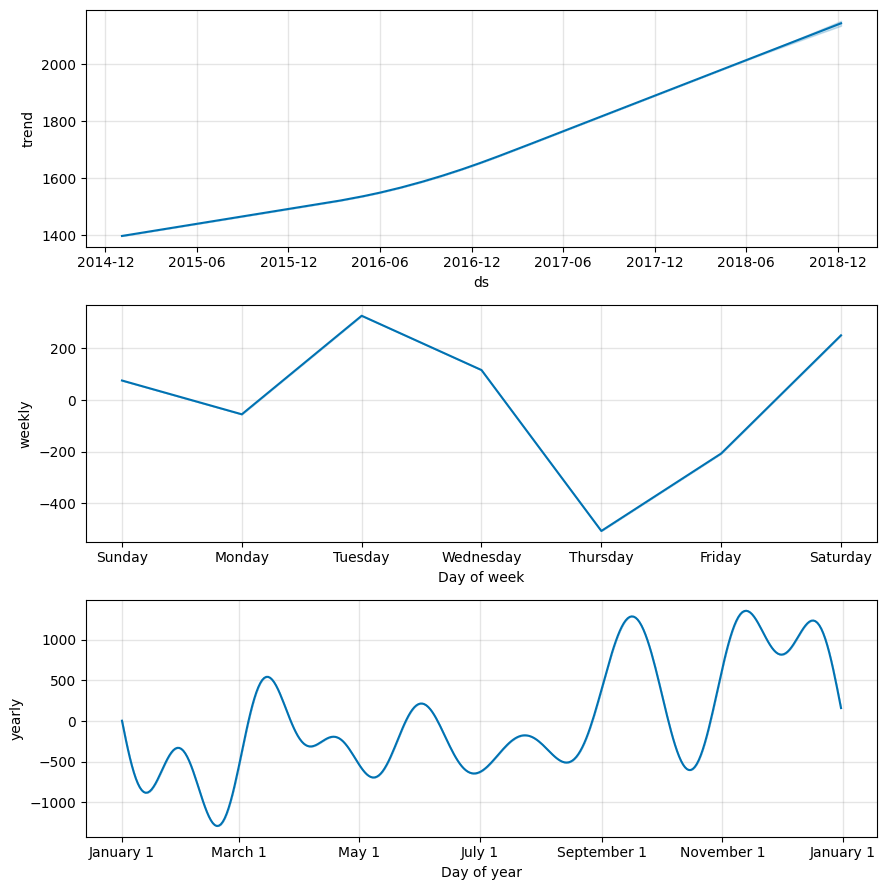


Final Model Comparison
ARIMA RMSE  : 2718.951833427117
Prophet RMSE: 2453.469508190253
Prophet performs better for this dataset.


In [6]:
# Sales Forecasting Project
# Purpose: Predict future sales using historical data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error


# 1. Load and understand the data

data = pd.read_csv("/content/train.csv")

# Convert date column into datetime format, using 'Order Date'
data['Order Date'] = pd.to_datetime(data['Order Date'], dayfirst=True)

# Combine all stores and items to get total daily sales, using 'Order Date'
daily_sales = data.groupby('Order Date')['Sales'].sum().reset_index()
daily_sales.columns = ['date', 'sales']

print(daily_sales.head())


# 2. Exploratory Data Analysis

plt.figure()
plt.plot(daily_sales['date'], daily_sales['sales'])
plt.title("Daily Sales Trend")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.show()



# 3. Train-Test Split

# Use 80% data for training and 20% for testing
split_index = int(len(daily_sales) * 0.8)

train = daily_sales.iloc[:split_index]
test = daily_sales.iloc[split_index:]



# 4. ARIMA Model

# ARIMA works well for time-based numerical data
arima_model = ARIMA(train['sales'], order=(5, 1, 0))
arima_fit = arima_model.fit()

# Predict sales for test period
arima_predictions = arima_fit.forecast(steps=len(test))

# Evaluate ARIMA
arima_mae = mean_absolute_error(test['sales'], arima_predictions)
arima_rmse = np.sqrt(mean_squared_error(test['sales'], arima_predictions))

print("\nARIMA Results")
print("MAE :", arima_mae)
print("RMSE:", arima_rmse)

# Plot ARIMA results
plt.figure()
plt.plot(train['date'], train['sales'], label='Training Data')
plt.plot(test['date'], test['sales'], label='Actual Sales')
plt.plot(test['date'], arima_predictions, label='ARIMA Prediction')
plt.legend()
plt.title("ARIMA Forecast vs Actual Sales")
plt.show()


# 5. Prophet Model

# Prophet requires specific column names
prophet_data = daily_sales.rename(columns={
    'date': 'ds',
    'sales': 'y'
})

prophet_train = prophet_data.iloc[:split_index]
prophet_test = prophet_data.iloc[split_index:]

# Create Prophet model
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

# Train model
prophet_model.fit(prophet_train)

# Predict future sales
future_dates = prophet_model.make_future_dataframe(
    periods=len(prophet_test)
)

forecast = prophet_model.predict(future_dates)

# Extract only test period predictions
prophet_predictions = forecast.iloc[split_index:]['yhat']

# Evaluate Prophet
prophet_mae = mean_absolute_error(prophet_test['y'], prophet_predictions)
prophet_rmse = np.sqrt(mean_squared_error(prophet_test['y'], prophet_predictions))

print("\nProphet Results")
print("MAE :", prophet_mae)
print("RMSE:", prophet_rmse)

# Plot Prophet results
plt.figure()
plt.plot(prophet_train['ds'], prophet_train['y'], label='Training Data')
plt.plot(prophet_test['ds'], prophet_test['y'], label='Actual Sales')
plt.plot(prophet_test['ds'], prophet_predictions, label='Prophet Prediction')
plt.legend()
plt.title("Prophet Forecast vs Actual Sales")
plt.show()

# Show trend and seasonality
prophet_model.plot_components(forecast)
plt.show()


# 6. Final Comparison

print("\nFinal Model Comparison")
print("ARIMA RMSE  :", arima_rmse)
print("Prophet RMSE:", prophet_rmse)

if prophet_rmse < arima_rmse:
    print("Prophet performs better for this dataset.")
else:
    print("ARIMA performs better for this dataset.")